In [1]:
pip install tensorflow-addons

Looking in indexes: https://mirrors.sjtug.sjtu.edu.cn/pypi/web/simple
     |████████████████████████████████| 591 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install vit-keras

Looking in indexes: https://mirrors.sjtug.sjtu.edu.cn/pypi/web/simple
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19583 sha256=9a54d7090db7fa83260ad7dec2f5f184af353558ae776800bc5e96dbd1941bb4
  Stored in directory: /root/.cache/pip/wheels/0f/47/e2/cefb461524715f403a95c55c710109e0907128aec3212b8c44
Successfully built validators
Note: you may need to restart the kernel to use updated packages.


In [ ]:
Raw - cluster 

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import cv2
import re
import sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

data_dir = 'train_cluster_raw'
cluster_numbers = list(range(1, 29))
cluster_folders = [os.path.join(data_dir, f'cluster_{i}') for i in cluster_numbers]

train_images = []
train_labels = []
validation_images = []
validation_labels = []

# Data preprocessing loop
for folder in cluster_folders:
    folder_images = []
    folder_labels = []
    
    file_names = os.listdir(folder)
    for file_name in file_names:
        cell_id = int(file_name.split('_')[1].split('.')[0])
        img = cv2.imread(os.path.join(folder, file_name))
        
        # Resize the image
        img_resized = cv2.resize(img, (224, 224))
        
        folder_images.append(img_resized)
        folder_labels.append(f'cluster_{folder.split("_")[-1]}')
    
    folder_images = np.array(folder_images)
    folder_labels = np.array(folder_labels)
    
    X_train_folder, X_validation_folder, y_train_folder, y_validation_folder = train_test_split(
        folder_images, folder_labels, test_size=0.2, random_state=42
    )
    
    train_images.extend(X_train_folder)
    train_labels.extend(y_train_folder)
    validation_images.extend(X_validation_folder)
    validation_labels.extend(y_validation_folder)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

lb = sklearn.preprocessing.LabelEncoder()
train_labels = lb.fit_transform(train_labels)
validation_labels = lb.transform(validation_labels)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(cluster_numbers))
validation_labels = tf.keras.utils.to_categorical(validation_labels, num_classes=len(cluster_numbers))

train_images = train_images.astype('float32') / 255.0
validation_images = validation_images.astype('float32') / 255.0


In [5]:
print(len(train_images))

23376


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import cv2
import re
import sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers



def create_vit_model(image_size, num_classes):
    vit_model = vit.vit_b32(
        image_size=image_size,
        activation='softmax',
        pretrained=False,
        include_top=True,
        pretrained_top=False,
        classes=num_classes
    )

    model = tf.keras.Model(inputs=vit_model.inputs, outputs=vit_model.outputs)
    return model

image_size = 224
num_classes = len(cluster_numbers)

model = create_vit_model(image_size, num_classes)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 30
batch_size = 128

data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_augmentation.flow(train_images, train_labels, batch_size=batch_size)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

models_dir = 'saved_4_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(models_dir, 'vit_raw_cluster3.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(validation_images, validation_labels),
    callbacks=[model_checkpoint]
)

model = tf.keras.models.load_model(os.path.join(models_dir, 'vit_raw_cluster3.h5'))


2023-05-11 12:02:52.761689: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 12:02:53.447392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:88:00.0, compute capability: 8.6


Epoch 1/30


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2023-05-11 12:03:15.799750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-05-11 12:03:17.540115: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


182/182 [==============================] - 277s 1s/step - loss: 3.2563 - accuracy: 0.1012 - val_loss: 3.0554 - val_accuracy: 0.1216
Epoch 2/30
182/182 [==============================] - 256s 1s/step - loss: 3.0708 - accuracy: 0.1181 - val_loss: 3.0201 - val_accuracy: 0.1395
Epoch 3/30
182/182 [==============================] - 254s 1s/step - loss: 3.0404 - accuracy: 0.1264 - val_loss: 3.0071 - val_accuracy: 0.1279
Epoch 4/30
182/182 [==============================] - 256s 1s/step - loss: 3.0161 - accuracy: 0.1280 - val_loss: 3.0063 - val_accuracy: 0.1248
Epoch 5/30
182/182 [==============================] - 256s 1s/step - loss: 3.0061 - accuracy: 0.1340 - val_loss: 2.9879 - val_accuracy: 0.1335
Epoch 6/30
182/182 [==============================] - 248s 1s/step - loss: 3.0036 - accuracy: 0.1343 - val_loss: 2.9726 - val_accuracy: 0.1453
Epoch 7/30
182/182 [==============================] - 230s 1s/step - loss: 2.9949 - accuracy: 0.1339 - val_loss: 2.9712 - val_accuracy: 0.1443
Epoch 8/30

In [8]:
# Create the output_csv folder if it doesn't exist
output_folder = "output_Image4_csv"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the training data to a CSV file
training_data = pd.DataFrame({
    'epoch': np.arange(1, len(history.history['accuracy']) + 1),
    'train_accuracy': history.history['accuracy'],
    'validation_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
})
training_data.to_csv(os.path.join(output_folder, 'history_vit_raw_cluster_3.csv'), index=False)

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

models_dir = 'saved_4_models'

model = tf.keras.models.load_model(os.path.join(models_dir, 'vit_raw_cluster_3.h5'))

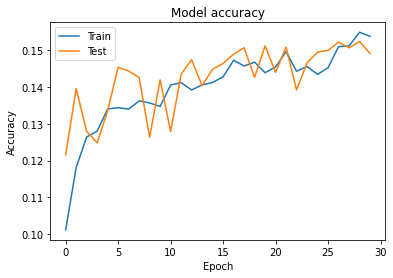

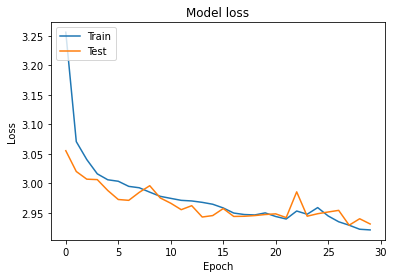

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = 'test_cluster_raw'

# Set up the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Found 7320 images belonging to 28 classes.


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 126s 2s/step - loss: 2.9347 - accuracy: 0.1564
Test loss: 2.9347
Test accuracy: 15.64%


In [11]:
import csv

# Predict on the test data generator
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Get the predicted labels with highest probabilities
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Get the probabilities of the predicted labels
y_pred_probabilities = np.max(y_pred, axis=1)

# Get the filenames of the test data
filenames = test_generator.filenames

# Extract the IDs from the filenames
ids = [filename.split("/")[-1].split("_")[-1].split(".")[0] for filename in filenames]

# Open the CSV file in write mode
with open('output_raw_stratified_transformers.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell ID', 'Label 1', 'Label 2', 'Label 3', 'Probability 1', 'Probability 2', 'Probability 3', 'Test Accuracy', 'Test Loss'])
    
    # Loop through the predictions
    for i in range(len(y_pred)):
        top_3_indices = y_pred[i].argsort()[-3:][::-1]
        top_3_labels = [class_labels[j] for j in top_3_indices]
        top_3_probabilities = y_pred[i][top_3_indices]
        
        # Write the row with predictions and the single test accuracy and test loss value
        writer.writerow([ids[i], top_3_labels[0], top_3_labels[1], top_3_labels[2], top_3_probabilities[0], top_3_probabilities[1], top_3_probabilities[2], test_accuracy, test_loss])

In [ ]:
Confusion matrix - FROM HERE ONWARDS 

In [22]:
# Get the true labels
true_labels = test_generator.classes
print(len(true_labels))

7320


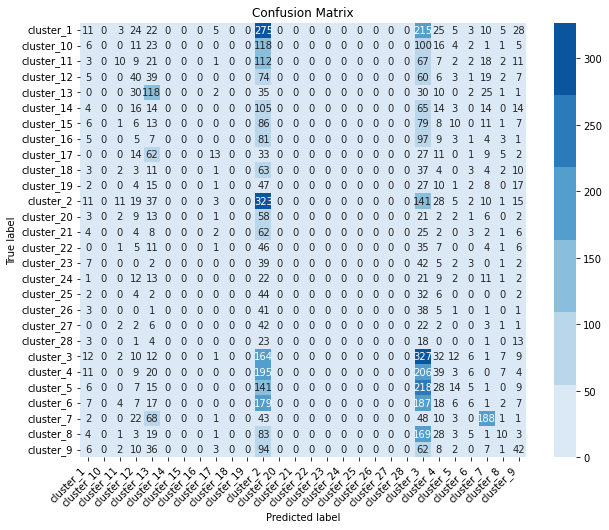

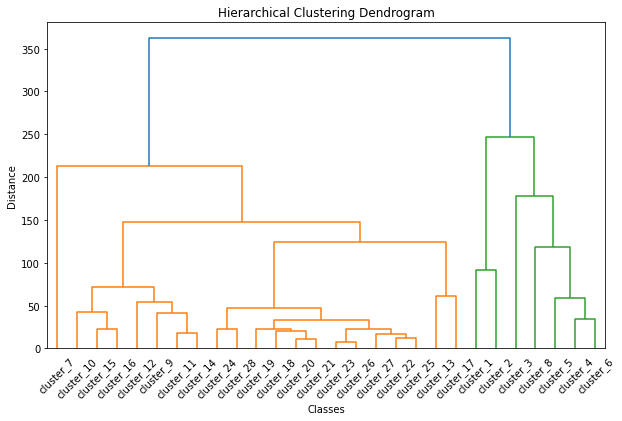

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix

# Get the number of samples in the test data
num_samples = len(y_pred)

# Trim y_pred_labels and y_pred_probabilities to match the number of samples
y_pred_labels = y_pred_labels[:num_samples]

# Create the confusion matrix
confusion_mat = confusion_matrix(test_generator.classes[:num_samples], y_pred_labels)

# Perform hierarchical clustering
Z = linkage(confusion_mat, method='complete')

# Get class labels for display
class_labels = list(test_generator.class_indices.keys())

# Set the color theme to light blue
cmap = sns.color_palette("Blues")

# Create a heatmap of the confusion matrix with light blue color theme
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap=cmap)

# Rotate the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Set labels and title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# Perform hierarchical clustering and plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=class_labels)

# Set labels and title for dendrogram
plt.xlabel("Classes")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram")

# Display the plots
plt.show()

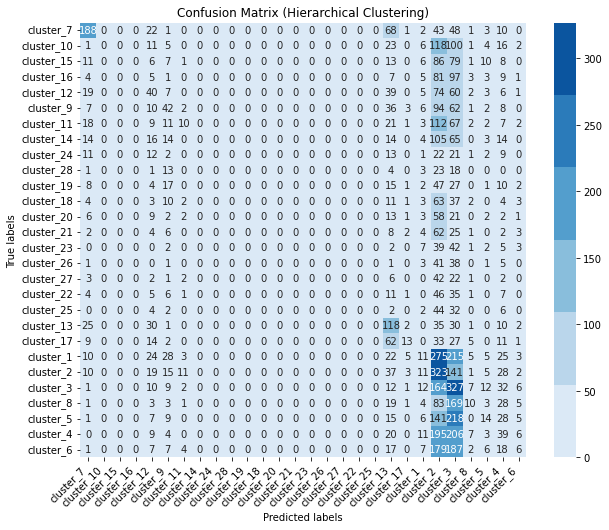

<Figure size 432x288 with 0 Axes>

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix

# Get the number of samples in the test data
num_samples = len(y_pred)

# Trim y_pred_labels and y_pred_probabilities to match the number of samples
y_pred_labels = y_pred_labels[:num_samples]

# Create the confusion matrix
confusion_mat = confusion_matrix(test_generator.classes[:num_samples], y_pred_labels)

# Perform hierarchical clustering
Z = linkage(confusion_mat, method='complete')

# Get the order of the clusters from the dendrogram
cluster_order = dendrogram(Z, no_plot=True)['leaves']
reordered_confusion_mat = confusion_mat[cluster_order, :]
reordered_confusion_mat = reordered_confusion_mat[:, cluster_order]

# Get the corresponding class labels for the reordered matrix
reordered_class_labels = [class_labels[idx] for idx in cluster_order]

# Set the color theme to light blue
cmap = sns.color_palette("Blues")

# Create a heatmap of the reordered confusion matrix with light blue color theme
plt.figure(figsize=(10, 8))
ax = sns.heatmap(reordered_confusion_mat, annot=True, fmt="d", xticklabels=reordered_class_labels, yticklabels=reordered_class_labels, cmap=cmap)

# Rotate the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Set labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Hierarchical Clustering)")

# Display the plot
plt.show()
# Save the figure
plt.savefig('confusion_matrix_vit_raw_cluster.png')  # Specify the filename and file format

SAAV 

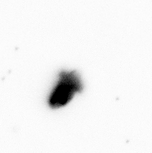

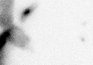

In [14]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow import keras

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

img_size = (224, 224)
last_conv_layer_name = "dense_3"

# The local path to our target image
img_path = "test_cluster_raw/cluster_1/cell_2255.png"
img_path2 = "test_cluster_raw/cluster_4/cell_3524.png"

from PIL import Image
from PIL import ImageOps

# Open the image
img = Image.open(img_path)
img2 = Image.open(img_path2)

# Invert the colors
inverted_img = ImageOps.invert(img)
inverted_img2 = ImageOps.invert(img2)

# Display the inverted image
inverted_img.show()
inverted_img2.show()

#display(Image.open(img_path))
#display(Image.open(img_path2))

SAAV 

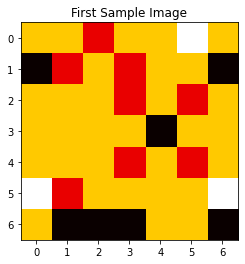

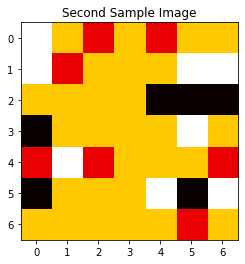

In [15]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

image_size = (224, 224)

# Load and preprocess the first image
image_path1 = "test_cluster_raw/cluster_1/cell_2255.png"
image1 = Image.open(image_path1).convert("RGB")
image1 = image1.resize(image_size)
image1 = np.array(image1) / 255.0
image1 = np.expand_dims(image1, axis=0)

# Get the self-attention maps for the first image
attention_maps1 = model.layers[1](image1, training=False)

# Normalize the attention maps for the first image
normalized_attention_maps1 = tf.nn.softmax(attention_maps1, axis=-1)

# Apply global average pooling to reduce dimensions
attention_maps1_pooled = tf.reduce_mean(normalized_attention_maps1, axis=-1)

# Visualize the attention maps for the first image
plt.imshow(attention_maps1_pooled[0], cmap='hot', interpolation='nearest')
plt.title('First Sample Image')
plt.show()

# Load and preprocess the second image
image_path2 = "test_cluster_raw/cluster_4/cell_3524.png"
image2 = Image.open(image_path2).convert("RGB")
image2 = image2.resize(image_size)
image2 = np.array(image2) / 255.0
image2 = np.expand_dims(image2, axis=0)

# Get the self-attention maps for the second image
attention_maps2 = model.layers[1](image2, training=False)

# Normalize the attention maps for the second image
normalized_attention_maps2 = tf.nn.softmax(attention_maps2, axis=-1)

# Apply global average pooling to reduce dimensions
attention_maps2_pooled = tf.reduce_mean(normalized_attention_maps2, axis=-1)

# Visualize the attention maps for the second image
plt.imshow(attention_maps2_pooled[0], cmap='hot', interpolation='nearest')
plt.title('Second Sample Image')
plt.show()
